# Q1: Studies for Air Quality vs (Traffic + Weather)

In [75]:
# Read csv
import pandas as pd
data = pd.read_csv('merged_10km_daily_updated.csv')


In [76]:
# Filter out the stations with no weather data (wx_n = 0 or wx_n is NA)
data_clean = data[data['wx_n'] != 0]
data_clean = data_clean[~data_clean['wx_n'].isna()]

# Filter out the stations with no traffic data (tr_n = 0 or tr_n is NA)
data_clean = data_clean[data_clean['tr_n'] != 0]
data_clean = data_clean[~data_clean['tr_n'].isna()]

# Check how many stations are left after filtering
print(f"Number of stations with weather and traffic data: {data_clean['Station ID'].nunique()}")

# Do a standardization for the traffic data by group id (Station ID)
g = data_clean.groupby("Station ID")["TotalTraffic"]
mu = g.transform("mean")
sd = g.transform("std")
data_clean["traffic_scaled"] = (data_clean["TotalTraffic"] - mu) / sd

# Set the Station ID and Date as the index for the dataset
data_clean['Date'] = pd.to_datetime(data_clean['Date'])
data_clean.set_index(['Station ID', 'Date'], inplace=True)
data_clean.sort_index(inplace=True)

Number of stations with weather and traffic data: 23


In [77]:
# Count the % of missing values for each weather & traffic variable across all stations
weather_traffic_variables = ['MeanTemp', 'TotalPrecip', 'MaxTemp', 'MinTemp', 'TotalRain', 'SnowOnGround', 'MaxGustSpd', 'wx_n', 'TempRange', 'traffic_scaled', 'TotalTraffic', 'tr_n']
missing_values_by_variable = data_clean[weather_traffic_variables].isnull().mean() * 100
print(missing_values_by_variable)

MeanTemp           0.735900
TotalPrecip        6.900988
MaxTemp            0.725607
MinTemp            0.730753
TotalRain         77.552491
SnowOnGround      73.296624
MaxGustSpd        44.838411
wx_n               0.000000
TempRange          0.735900
traffic_scaled     0.000000
TotalTraffic       0.000000
tr_n               0.000000
dtype: float64


We can see that the 'TotalRain', 'SnowOnGround', and 'MaxGustSpd' variables have a high percentage of missing values (over 40%), so we drop these variables from our analysis. In this case, we use only 'MeanTemp', 'TotalPrecip','TempRange', 'traffic_scaled' as the X variables. Also, by some previous studies, we found that one of the stations has no 'TotalPrecip' data, so we drop that station from our analysis as well. After dropping the variables and the station, we impute the remaining missing values using the KNN imputation method.

In [78]:
# Drop the stations with no TotalPrecip data
col = "TotalPrecip"
bad_stations = (
    data_clean[col]
    .groupby(level="Station ID")
    .apply(lambda s: s.notna().any()) 
)

bad_station_ids = bad_stations.index[~bad_stations].tolist()
print(len(bad_station_ids))
print(bad_station_ids[:20])

# Drop the stations with no TotalPrecip data
data_clean = data_clean.drop(index=bad_station_ids, level="Station ID")

1
[27067]


In [79]:
# Use Iterative Imputer to fill up the missing values for the weather & traffic variables
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(random_state=0)

# Filter out the dropped variables and set up the x and y variables for modelling
x_variables = ['MeanTemp', 'TotalPrecip','TempRange', 'traffic_scaled']
y_variable = ['AQI']

X = data_clean[x_variables].copy()
y = data_clean[y_variable].copy()

# For X variables, impute the missing values using Iterative Imputer, by their Station ID groups
def impute_one_station(g):
    imputer = IterativeImputer(random_state=0)  # One imputer per station group
    X = g[x_variables]
    X_imp = pd.DataFrame(imputer.fit_transform(X), columns=x_variables, index=g.index)
    g.loc[:, x_variables] = X_imp
    return g

data_imp = (
    data_clean.copy()
    .groupby(level="Station ID", group_keys=False)
    .apply(impute_one_station)
)

X_imputed = data_imp[x_variables]
# Note that y has no missing values, so we can keep it as is
data_imputed = pd.concat([X_imputed, y], axis=1)

In [80]:
# Save the cleaned dataset to a new CSV file
data_imputed.to_csv('final_data.csv')

After cleaning the data, we then try to fit models for y (AQI) vs X (the 4 variables mentioned above). We use the following models: Linear Regression, Elastic Net, XGBoost, RF, and Neural Networks. We use 5-fold CV to evaluate the performance of the models.

Also, note that in previous we have set the Station ID and Date as index. For the better forecasting performance, we still want to use the station ID as a feature. So we reset the index and then one-hot encode the station ID variable. After that, we have 4 original X variables + 1 station ID variable (after one-hot encoding) as our final X variables for modeling.

In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

df = data_imputed.reset_index()
df["Station ID"] = df["Station ID"].astype("category") # Convert Station ID to categorical type

X = df[x_variables + ["Station ID", "Date"]].copy()
y = df["AQI"]

# Get features from Date
X["month"] = df["Date"].dt.month
X["dow"] = df["Date"].dt.dayofweek
X["doy"] = df["Date"].dt.dayofyear
X = X.drop(columns=["Date"])

Build the forecasting dataset with lags. Note that by some previous studies, we found that the lag of 1 day data is strongly correlated with the current day data. So instead of predicting the next day AQI, we try to predict the differenced data, i.e., AQI(t) - AQI(t-1), using the lag of 1 day data, i.e., X(t-1). We also include the current day data, i.e., X(t), as features for modeling. So our final forecasting dataset has the following features: X(t-1) and X(t), and the target variable is AQI(t) - AQI(t-1).

In [82]:
# import numpy as np
# import pandas as pd

# # ---------------------------
# # 1) Build a one-step-ahead forecasting dataset (delta target):
# #    predict Δy(t) = y(t) - y(t-1) using lagged features within each Station ID
# # ---------------------------

# x_vars = ['MeanTemp', 'TotalPrecip', 'TempRange', 'traffic_scaled']
# y_var = 'AQI'

# # Assume data_imputed is already imputed and indexed by ['Station ID', 'Date']
# df = data_imputed.copy().sort_index()

# g = df.groupby(level="Station ID")

# # (A) Lags for X and y
# lag_list_x = [1, 7]
# lag_list_y = [1, 7, 14]

# for c in x_vars:
#     for L in lag_list_x:
#         df[f"{c}_lag{L}"] = g[c].shift(L)

# for L in lag_list_y:
#     df[f"{y_var}_lag{L}"] = g[y_var].shift(L)

# # (B) Rolling statistics (use only past information)
# df[f"{y_var}_rm7"]  = g[y_var].transform(lambda s: s.shift(1).rolling(window=7,  min_periods=7).mean())
# df[f"{y_var}_rm14"] = g[y_var].transform(lambda s: s.shift(1).rolling(window=14, min_periods=14).mean())
# df[f"{y_var}_rs7"]  = g[y_var].transform(lambda s: s.shift(1).rolling(window=7,  min_periods=7).std())

# df["traffic_scaled_rm7"] = g["traffic_scaled"].transform(
#     lambda s: s.shift(1).rolling(window=7, min_periods=7).mean()
# )

# # (Target) Delta target: Δy(t) = y(t) - y(t-1)
# # y_lag1 is already computed as AQI_lag1
# df["y_target"] = df[y_var] - df[f"{y_var}_lag1"]

# # Keep the base level y(t-1) so we can reconstruct y(t) after prediction
# df["y_base"] = df[f"{y_var}_lag1"]

# # Collect feature columns
# feature_cols = []

# for c in x_vars:
#     for L in lag_list_x:
#         feature_cols.append(f"{c}_lag{L}")

# for L in lag_list_y:
#     feature_cols.append(f"{y_var}_lag{L}")

# feature_cols += [f"{y_var}_rm7", f"{y_var}_rm14", f"{y_var}_rs7", "traffic_scaled_rm7"]

# # (C) Time features (seasonality and calendar effects)
# date_idx = df.index.get_level_values("Date")
# df["month"] = date_idx.month
# df["dow"] = date_idx.dayofweek
# df["doy_sin"] = np.sin(2 * np.pi * date_idx.dayofyear / 365.25)
# df["doy_cos"] = np.cos(2 * np.pi * date_idx.dayofyear / 365.25)
# feature_cols += ["month", "dow", "doy_sin", "doy_cos"]

# # Bring Station ID / Date back as columns so they can be used in sklearn
# df = df.reset_index()
# df["Station ID"] = df["Station ID"].astype(str)

# # Drop rows that become NaN due to lagging/rolling
# model_df = (
#     df.replace([np.inf, -np.inf], np.nan)
#       .dropna(subset=feature_cols + ["y_target", "y_base"])
#       .copy()
# )

# X = model_df[feature_cols + ["Station ID"]]
# y = model_df["y_target"]     # <-- delta target
# y_base = model_df["y_base"]  # <-- y(t-1), used to reconstruct y(t)
# dates = model_df["Date"]
# y_level = model_df[y_var]

In [83]:
import numpy as np
import pandas as pd

# ---------------------------
# 1) Build a one-step-ahead forecasting dataset:
#    predict y(t) using lagged features within each Station ID
# ---------------------------

x_vars = ['MeanTemp', 'TotalPrecip', 'TempRange', 'traffic_scaled']
y_var = 'AQI'

# Assume data_imputed is already imputed and indexed by ['Station ID', 'Date']
df = data_imputed.copy().sort_index()

g = df.groupby(level="Station ID")

# (A) Lags for X and y
lag_list_x = [1, 7]          # you can extend to [1, 2, 3, 7, 14]
lag_list_y = [1, 7, 14]

for c in x_vars:
    for L in lag_list_x:
        df[f"{c}_lag{L}"] = g[c].shift(L)

for L in lag_list_y:
    df[f"{y_var}_lag{L}"] = g[y_var].shift(L)

# (B) Rolling statistics (use only past information)
# Important: shift(1) BEFORE rolling to avoid using y(t) itself
# Use groupby.transform to preserve the original MultiIndex (Station ID, Date)
df[f"{y_var}_rm7"] = g[y_var].transform(lambda s: s.shift(1).rolling(window=7,  min_periods=7).mean())
df[f"{y_var}_rm14"] = g[y_var].transform(lambda s: s.shift(1).rolling(window=14, min_periods=14).mean())
df[f"{y_var}_rs7"] = g[y_var].transform(lambda s: s.shift(1).rolling(window=7,  min_periods=7).std())

# Optional: rolling mean for traffic (often helpful)
df["traffic_scaled_rm7"] = g["traffic_scaled"].transform(lambda s: s.shift(1).rolling(window=7, min_periods=7).mean())

# The target is current y(t)
df["y_target"] = df[y_var]

# Collect feature columns
feature_cols = []

# X lags
for c in x_vars:
    for L in lag_list_x:
        feature_cols.append(f"{c}_lag{L}")

# y lags
for L in lag_list_y:
    feature_cols.append(f"{y_var}_lag{L}")

# rolling features
feature_cols += [f"{y_var}_rm7", f"{y_var}_rm14", f"{y_var}_rs7", "traffic_scaled_rm7"]

# (C) Time features (seasonality and calendar effects)
date_idx = df.index.get_level_values("Date")
df["month"] = date_idx.month
df["dow"] = date_idx.dayofweek
df["doy_sin"] = np.sin(2 * np.pi * date_idx.dayofyear / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * date_idx.dayofyear / 365.25)
feature_cols += ["month", "dow", "doy_sin", "doy_cos"]

# Bring Station ID / Date back as columns so they can be used in sklearn
df = df.reset_index()

# Force Station ID to be treated as categorical (not numeric/ordinal)
df["Station ID"] = df["Station ID"].astype(str)

# Drop rows that become NaN due to lagging/rolling (first few days per station)
model_df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=feature_cols + ["y_target"]).copy()

X = model_df[feature_cols + ["Station ID"]]
y = model_df["y_target"]
dates = model_df["Date"]


In [84]:
# ---------------------------
# 2) Time-based split for forecasting (no random shuffle)
#    Example: last 20% of dates as the test set
# ---------------------------

# cutoff = dates.quantile(0.8)
# train_idx = dates <= cutoff
# test_idx = dates > cutoff

# X_train, y_train = X.loc[train_idx], y.loc[train_idx]   # delta target
# X_test  = X.loc[test_idx]

# y_base_train, y_base_test = y_base.loc[train_idx], y_base.loc[test_idx]
# y_level_train, y_level_test = y_level.loc[train_idx], y_level.loc[test_idx]

cutoff = dates.quantile(0.8)
train_idx = dates <= cutoff
test_idx = dates > cutoff

X_train, y_train = X.loc[train_idx], y.loc[train_idx]
X_test, y_test = X.loc[test_idx], y.loc[test_idx]

# ---------------------------
# 3) Preprocessing: one-hot encode Station ID + scale numeric features
#    Scaling is important for linear models and neural networks
# ---------------------------

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

cat_cols = ["Station ID"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess_linear = ColumnTransformer( # For the linear models (OLS, Elastic Net, NN)
    [("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
     ("num", StandardScaler(), num_cols)],
    remainder="drop",
)

preprocess_tree = ColumnTransformer( # For tree-based models (RF, XGBoost)
    [("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
     ("num", "passthrough", num_cols)], # Do not include standardization for tree-based models
    remainder="drop",
)

# 4) Set up 5-fold CV within training set, and set up RMSE as the evaluation metric for hyperparameter tuning
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
tscv = TimeSeriesSplit(n_splits=5)

Set up the models, here we use Linear Regression, Elastic Net, XGBoost, RF, and Neural Networks.

In [85]:
# OLS
from sklearn.linear_model import LinearRegression

ols_pipe = Pipeline([
    ("prep", preprocess_linear),
    ("model", LinearRegression())
])
ols_pipe.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [86]:
# Elastic Net
from sklearn.linear_model import ElasticNet

enet_pipe = Pipeline([
    ("prep", preprocess_linear),
    ("model", ElasticNet(random_state=0, max_iter=20000))
])

enet_param = {
    "model__alpha": np.logspace(-4, 1, 30),
    "model__l1_ratio": np.linspace(0.05, 0.95, 19),
}
enet_search = RandomizedSearchCV(
    enet_pipe, enet_param,
    n_iter=60, cv=tscv,
    scoring="neg_root_mean_squared_error",
    random_state=0, n_jobs=-1,
    error_score="raise"
)
enet_search.fit(X_train, y_train)
print("ElasticNet best:", enet_search.best_params_, -enet_search.best_score_)


ElasticNet best: {'model__l1_ratio': 0.7999999999999999, 'model__alpha': 0.12689610031679235} 14.900647853547065


In [87]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_pipe = Pipeline([
    ("prep", preprocess_tree),
    ("model", RandomForestRegressor(random_state=0, n_jobs=-1))
])

rf_param = {
    "model__n_estimators": [300, 600, 1000],
    "model__max_depth": [None, 6, 10, 16],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__min_samples_split": [2, 5, 10],
    "model__max_features": ["sqrt", 0.5, 0.8],
}

rf_search = RandomizedSearchCV(
    rf_pipe, rf_param,
    n_iter=40, cv=tscv,
    scoring="neg_root_mean_squared_error",
    random_state=0, n_jobs=-1,
    error_score="raise",
    verbose=2, return_train_score=True
)

rf_search.fit(X_train, y_train)
print("RF best:", rf_search.best_params_, -rf_search.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
RF best: {'model__n_estimators': 600, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 0.5, 'model__max_depth': None} 13.051289286926556


In [88]:
# XGBoost
from xgboost import XGBRegressor

xgb_pipe = Pipeline([
    ("prep", preprocess_tree),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        random_state=0,
        n_jobs=-1,
        tree_method="hist"
    ))
])

xgb_param = {
    "model__n_estimators": [300, 600, 1000],
    "model__learning_rate": [0.01, 0.03, 0.05],
    "model__max_depth": [2, 3, 4, 6],
    "model__min_child_weight": [5, 10, 20],
    "model__subsample": [0.6, 0.8],
    "model__colsample_bytree": [0.6, 0.8],
    "model__reg_lambda": [1.0, 2.0, 5.0, 10.0],
    "model__reg_alpha": [0.0, 0.1, 0.5, 1.0],
}

xgb_search = RandomizedSearchCV(
    xgb_pipe, xgb_param,
    n_iter=50, cv=tscv,
    scoring="neg_root_mean_squared_error",
    random_state=0, n_jobs=-1,
    error_score="raise",
    verbose=1
)

xgb_search.fit(X_train, y_train)
print("XGB best:", xgb_search.best_params_, -xgb_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGB best: {'model__subsample': 0.8, 'model__reg_lambda': 2.0, 'model__reg_alpha': 0.5, 'model__n_estimators': 600, 'model__min_child_weight': 5, 'model__max_depth': 6, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.6} 12.595515135670704


In [89]:
# Neural Network
from sklearn.neural_network import MLPRegressor

mlp_pipe = Pipeline([
    ("prep", preprocess_linear),
    ("model", MLPRegressor(
        random_state=0,
        early_stopping=True,
        max_iter=2000
    ))
])

mlp_param = {
    "model__hidden_layer_sizes": [(64,), (128,), (128, 64), (256, 128), (128, 64, 32)],
    "model__alpha": np.logspace(-6, -2, 10),      # L2 penalty
    "model__learning_rate_init": [1e-4, 3e-4, 1e-3, 3e-3],
}
mlp_search = RandomizedSearchCV(
    mlp_pipe, mlp_param,
    n_iter=30, cv=tscv,
    scoring="neg_root_mean_squared_error",
    error_score="raise",
    random_state=0, n_jobs=-1,
    verbose=2, return_train_score=True
)
mlp_search.fit(X_train, y_train)
print("MLP best:", mlp_search.best_params_, -mlp_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
MLP best: {'model__learning_rate_init': 0.003, 'model__hidden_layer_sizes': (128, 64, 32), 'model__alpha': 0.003593813663804626} 15.424371328263524


In [90]:
# Evaluate all models on the test set using RMSE and MAE
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def eval_model(name, fitted_model):
    pred = fitted_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    return name, rmse, mae

final_results = []
final_results.append(eval_model("OLS", ols_pipe))
final_results.append(eval_model("ElasticNet", enet_search.best_estimator_))
final_results.append(eval_model("RF", rf_search.best_estimator_))
final_results.append(eval_model("XGBoost", xgb_search.best_estimator_))
final_results.append(eval_model("MLP", mlp_search.best_estimator_))

res_df = pd.DataFrame(final_results, columns=["model", "RMSE_test", "MAE_test"]).sort_values("RMSE_test")
print(res_df)


        model  RMSE_test   MAE_test
0         OLS  11.958300   9.057869
1  ElasticNet  12.023960   9.102588
2          RF  12.594039   9.587891
3     XGBoost  13.537576  10.273238
4         MLP  14.058493  10.394399


In [91]:
# from sklearn.metrics import root_mean_squared_error, mean_absolute_error

# def eval_model_delta(name, fitted_model, X_test, y_test_level, y_base_test):
#     delta_pred = fitted_model.predict(X_test)
#     y_pred = y_base_test.values + delta_pred  # reconstruct level: y(t-1) + Δy_hat
#     rmse = root_mean_squared_error(y_test_level, y_pred)
#     mae = mean_absolute_error(y_test_level, y_pred)
#     return name, rmse, mae

# final_results = []
# final_results.append(eval_model_delta("OLS", ols_pipe, X_test, y_level_test, y_base_test))
# final_results.append(eval_model_delta("ElasticNet", enet_search.best_estimator_, X_test, y_level_test, y_base_test))
# final_results.append(eval_model_delta("RF", rf_search.best_estimator_, X_test, y_level_test, y_base_test))
# final_results.append(eval_model_delta("XGBoost", xgb_search.best_estimator_, X_test, y_level_test, y_base_test))
# final_results.append(eval_model_delta("MLP", mlp_search.best_estimator_, X_test, y_level_test, y_base_test))

# res_df = pd.DataFrame(final_results, columns=["model", "RMSE_test", "MAE_test"]).sort_values("RMSE_test")
# print(res_df)


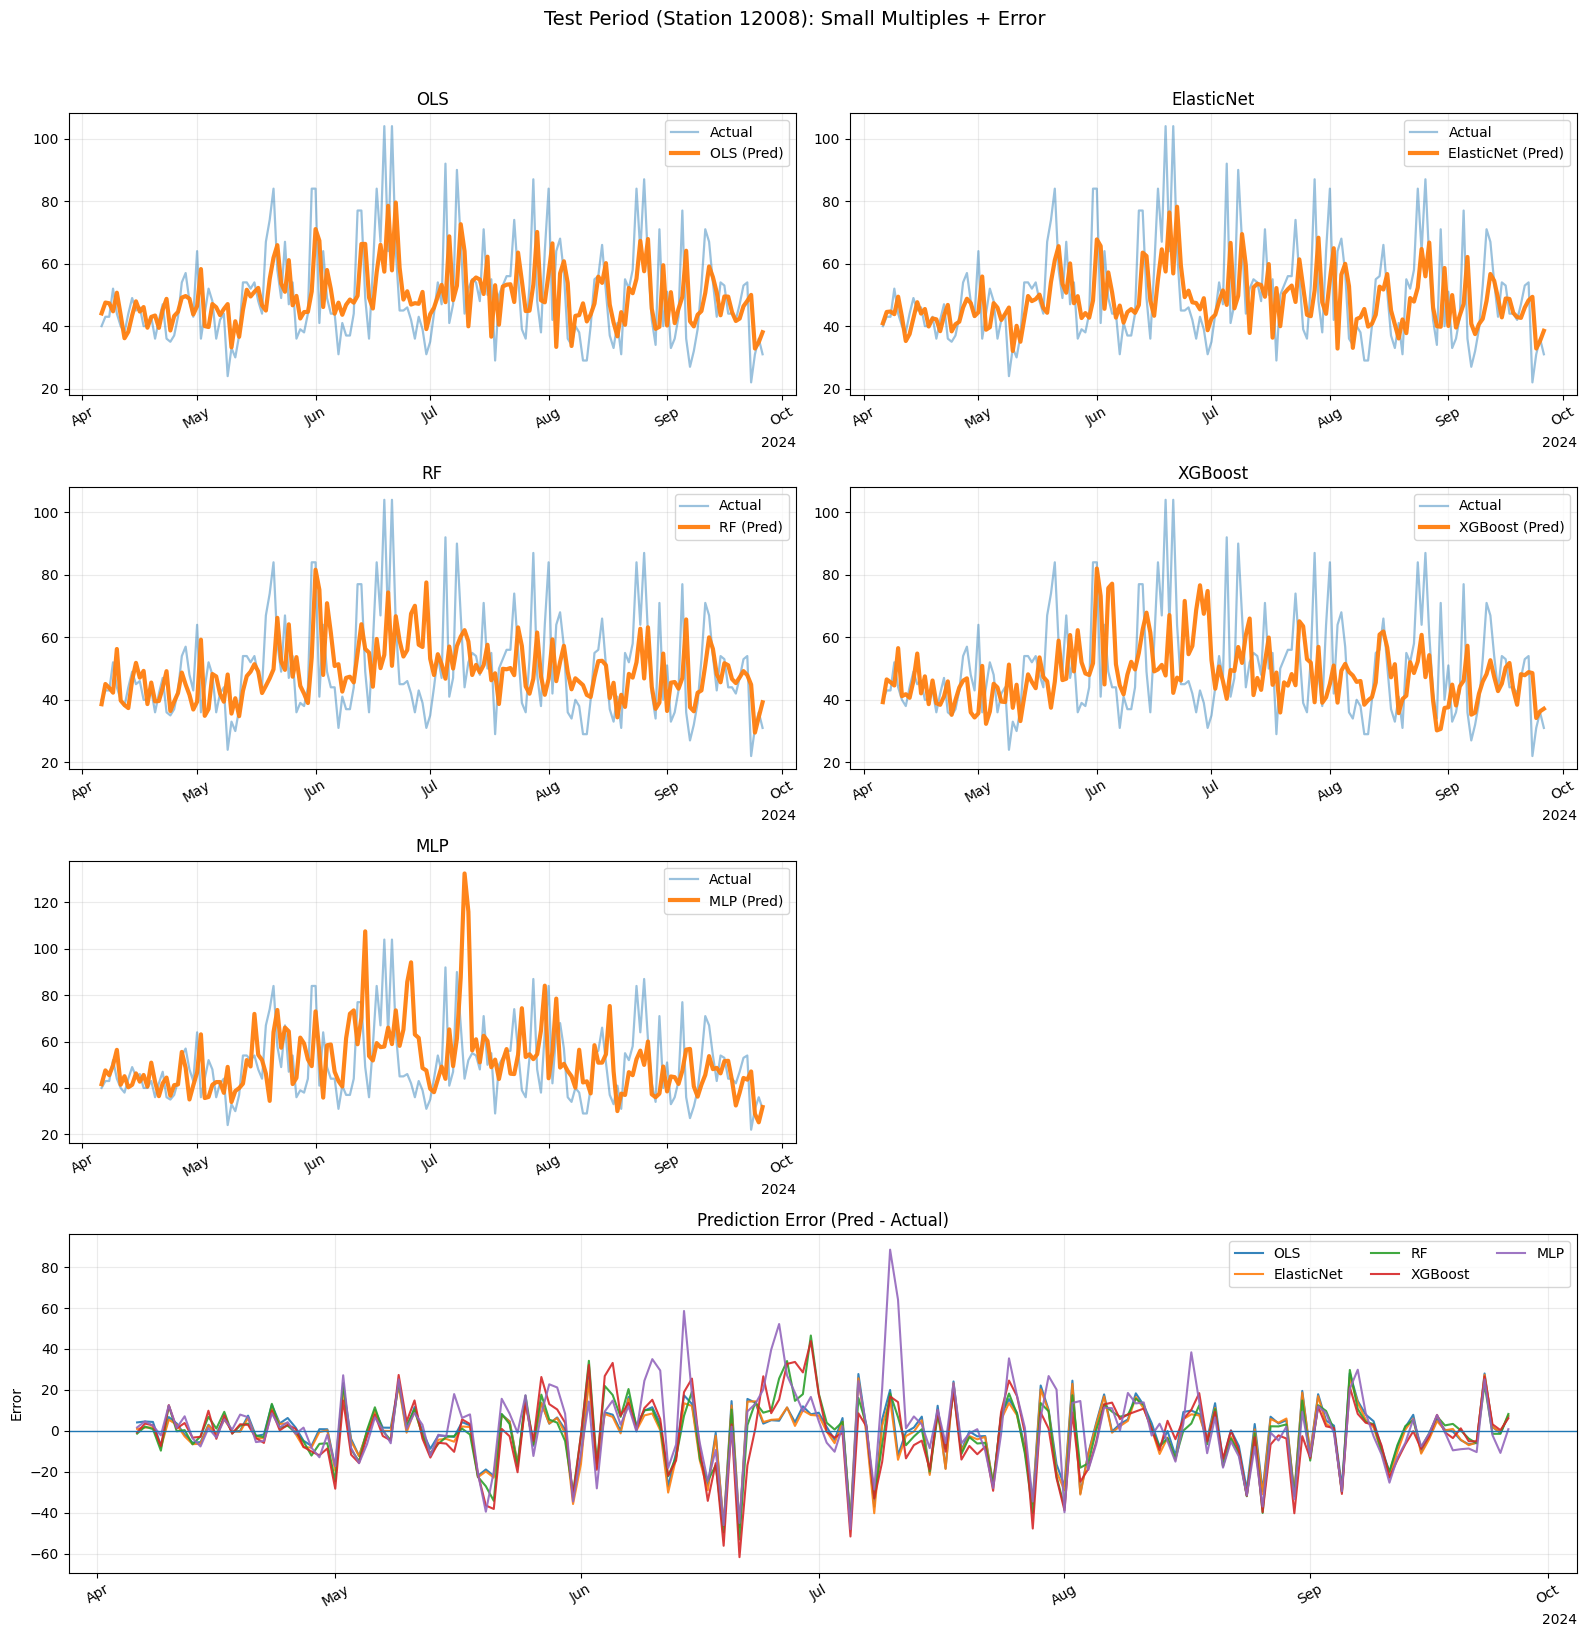

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -----------------------------
# One figure:
#   Top: small multiples (Actual vs Pred) for each model (Pred emphasized)
#   Bottom: error plot (Pred - Actual) for all models
# Station fixed to 12008
# -----------------------------

station_to_plot = "12008"
last_n_days = None  # set to e.g. 120 if you want only last 120 test days

models = {
    "OLS": ols_pipe,
    "ElasticNet": enet_search.best_estimator_,
    "RF": rf_search.best_estimator_,
    "XGBoost": xgb_search.best_estimator_,
    "MLP": mlp_search.best_estimator_,
}

# 1) Filter ONE station in the test period
dfp = model_df.copy()
dfp["Date"] = pd.to_datetime(dfp["Date"])
dfp["Station ID"] = dfp["Station ID"].astype(str)

st = dfp[(dfp["Station ID"] == station_to_plot) & (dfp["Date"] > cutoff)].copy()
if st.empty:
    raise ValueError("No rows found for Station 12008 in the test period. Check cutoff or Station ID.")

# 2) Aggregate duplicate dates (daily) to avoid messy lines
st = (
    st.sort_values("Date")
      .groupby("Date", as_index=False)[feature_cols + ["AQI"]]
      .mean(numeric_only=True)
)

# Optionally keep only the last N days
if last_n_days is not None and len(st) > last_n_days:
    st = st.iloc[-last_n_days:].copy()

# 3) Build X and predictions (Station ID must be present for the pipelines)
X_station = st[feature_cols].copy()
X_station["Station ID"] = station_to_plot

y_true = st["AQI"].to_numpy()
dates = st["Date"].to_numpy()

preds = {name: m.predict(X_station) for name, m in models.items()}

# 4) Plot layout
model_names = list(preds.keys())
n = len(model_names)
ncols = 2
nrows_top = int(np.ceil(n / ncols))

fig = plt.figure(figsize=(16, 4 * nrows_top + 4))
gs = fig.add_gridspec(nrows=nrows_top + 1, ncols=ncols, height_ratios=[1] * nrows_top + [1.2])

# Date formatting
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)

# Styling knobs to emphasize predictions in small multiples
actual_kwargs = dict(label="Actual", linewidth=1.6, alpha=0.45, zorder=2)
pred_kwargs = dict(linewidth=3.0, alpha=0.95, zorder=3)  # more prominent

# ---- Top: small multiples
for i, name in enumerate(model_names):
    r = i // ncols
    c = i % ncols
    ax = fig.add_subplot(gs[r, c])

    # Plot actual (de-emphasized)
    ax.plot(dates, y_true, **actual_kwargs)

    # Plot prediction (emphasized)
    ax.plot(dates, preds[name], label=f"{name} (Pred)", **pred_kwargs)

    ax.set_title(name)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.tick_params(axis="x", rotation=30)
    ax.grid(True, alpha=0.25)

    # Put legend in the same place and make it compact
    ax.legend(loc="upper right", frameon=True)

# Hide unused top slots (if any)
total_slots = nrows_top * ncols
for j in range(n, total_slots):
    r = j // ncols
    c = j % ncols
    ax = fig.add_subplot(gs[r, c])
    ax.axis("off")

# ---- Bottom: error plot (Pred - Actual)
ax_err = fig.add_subplot(gs[nrows_top, :])
for name in model_names:
    err = np.asarray(preds[name]) - y_true
    ax_err.plot(dates, err, label=name, alpha=0.9)

ax_err.axhline(0, linewidth=1)
ax_err.set_title("Prediction Error (Pred - Actual)")
ax_err.set_ylabel("Error")
ax_err.xaxis.set_major_locator(locator)
ax_err.xaxis.set_major_formatter(formatter)
ax_err.tick_params(axis="x", rotation=30)
ax_err.grid(True, alpha=0.25)
ax_err.legend(ncol=3, loc="upper right")

fig.suptitle("Test Period (Station 12008): Small Multiples + Error", y=1.02, fontsize=14)
fig.tight_layout()
plt.show()


Plot, testing period AQI vs predicted AQI. And the prediction error.

In [93]:
print(X_test['Station ID'].unique())

['12008' '12016' '14111' '15026' '21005' '28028' '29000' '29118' '29214'
 '31129' '35125' '44008' '45027' '47045' '49005' '51001' '52023' '54012'
 '56051' '63203' '75010']


### Test Results with differencing
model  RMSE_test   MAE_test
0         OLS  11.958300   9.057869
1  ElasticNet  12.001343   9.001696
4         MLP  12.653177   9.551275
2          RF  13.088501   9.784083
3     XGBoost  13.477445  10.101334


# Export the model and data for report

In [ ]:
# Export the trained models using joblib

import os, joblib

os.makedirs("exports/models", exist_ok=True)

joblib.dump(ols_pipe, "exports/models/ols_pipe.joblib")
joblib.dump(enet_search.best_estimator_, "exports/models/elasticnet_best.joblib")
joblib.dump(rf_search.best_estimator_, "exports/models/rf_best.joblib")
joblib.dump(xgb_search.best_estimator_, "exports/models/xgb_best.joblib")
joblib.dump(mlp_search.best_estimator_, "exports/models/mlp_best.joblib")

['exports/models/mlp_best.joblib']

In [102]:
import json, os
import pandas as pd

os.makedirs("exports/data", exist_ok=True)

json.dump(feature_cols, open("exports/data/feature_cols.json", "w"))

# cutoff is a Timestamp, we can save it as a string in a CSV file
pd.Series([cutoff]).to_csv("exports/data/cutoff.csv", index=False, header=["cutoff"])

dfp = model_df.copy()
dfp["Date"] = pd.to_datetime(dfp["Date"])
dfp["Station ID"] = dfp["Station ID"].astype(str)

# (1) Full test set for evaluation (all stations, no aggregation)
test_all = dfp[dfp["Date"] > cutoff][["Date", "Station ID", "AQI"] + feature_cols].copy()
test_all.to_csv("exports/data/test_all.csv", index=False)

# (2) Station 12008 daily test for plotting (aggregate by Date)
st12008 = dfp[(dfp["Station ID"] == "12008") & (dfp["Date"] > cutoff)].copy()
st12008 = (
    st12008.sort_values("Date")
           .groupby("Date", as_index=False)[feature_cols + ["AQI"]]
           .mean(numeric_only=True)
)
st12008.to_csv("exports/data/station12008_test_daily.csv", index=False)